In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
file_path = "/content/patient_priority.csv"  # Adjust if necessary
data = pd.read_csv(file_path)

data.head()

,Unnamed: 0,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type,smoking_status,triage
0,0,40.0,1.0,2.0,140.0,294.0,172.0,0.0,108.0,43.0,92.0,19.0,0.467386,0.0,0.0,Urban,never smoked,yellow
1,1,49.0,0.0,3.0,160.0,180.0,156.0,0.0,75.0,47.0,90.0,18.0,0.467386,0.0,0.0,Urban,never smoked,orange
2,2,37.0,1.0,2.0,130.0,294.0,156.0,0.0,98.0,53.0,102.0,23.0,0.467386,0.0,0.0,Urban,never smoked,yellow
3,3,48.0,0.0,4.0,138.0,214.0,156.0,1.0,72.0,51.0,118.0,18.0,0.467386,0.0,0.0,Urban,never smoked,orange
4,4,54.0,1.0,3.0,150.0,195.0,156.0,0.0,108.0,90.0,83.0,21.0,0.467386,0.0,0.0,Urban,never smoked,yellow


2) Remove the patient ID as it does not contribute to the model's training

In [50]:
data = data.drop(data.columns[0], axis=1)
data.head()

,age,gender,chest pain type,blood pressure,cholesterol,max heart rate,exercise angina,plasma glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,Residence_type,smoking_status,triage
0,40.0,1.0,2.0,140.0,294.0,172.0,0.0,108.0,43.0,92.0,19.0,0.467386,0.0,0.0,Urban,never smoked,yellow
1,49.0,0.0,3.0,160.0,180.0,156.0,0.0,75.0,47.0,90.0,18.0,0.467386,0.0,0.0,Urban,never smoked,orange
2,37.0,1.0,2.0,130.0,294.0,156.0,0.0,98.0,53.0,102.0,23.0,0.467386,0.0,0.0,Urban,never smoked,yellow
3,48.0,0.0,4.0,138.0,214.0,156.0,1.0,72.0,51.0,118.0,18.0,0.467386,0.0,0.0,Urban,never smoked,orange
4,54.0,1.0,3.0,150.0,195.0,156.0,0.0,108.0,90.0,83.0,21.0,0.467386,0.0,0.0,Urban,never smoked,yellow


In [51]:

# Filter relevant fields
fields = ['age', 'gender', 'blood pressure', 'cholesterol', 'max heart rate',
          'insulin', 'bmi', 'triage']
data = data[fields]

data.dropna(inplace=True)

data.head()

<ipython-input-51-bff96c15810d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


,age,gender,blood pressure,cholesterol,max heart rate,insulin,bmi,triage
0,40.0,1.0,140.0,294.0,172.0,92.0,19.0,yellow
1,49.0,0.0,160.0,180.0,156.0,90.0,18.0,orange
2,37.0,1.0,130.0,294.0,156.0,102.0,23.0,yellow
3,48.0,0.0,138.0,214.0,156.0,118.0,18.0,orange
4,54.0,1.0,150.0,195.0,156.0,83.0,21.0,yellow


In [52]:
# Encode categorical variables
data['triage'] = data['triage'].map({'green': 0, 'yellow': 1, 'orange': 2, 'red': 3})
print(data.to_string())


<ipython-input-52-367e1f8bfec3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['triage'] = data['triage'].map({'green': 0, 'yellow': 1, 'orange': 2, 'red': 3})


       age  gender  blood pressure  cholesterol  max heart rate  insulin   bmi  triage
0     40.0     1.0           140.0        294.0           172.0     92.0  19.0       1
1     49.0     0.0           160.0        180.0           156.0     90.0  18.0       2
2     37.0     1.0           130.0        294.0           156.0    102.0  23.0       1
3     48.0     0.0           138.0        214.0           156.0    118.0  18.0       2
4     54.0     1.0           150.0        195.0           156.0     83.0  21.0       1
5     39.0     1.0           120.0        294.0           170.0    106.0  21.0       2
6     45.0     0.0           130.0        237.0           170.0     97.0  23.0       1
7     54.0     1.0           110.0        208.0           142.0    103.0  19.0       1
8     37.0     1.0           140.0        207.0           142.0    120.0  22.0       2
9     48.0     0.0           120.0        294.0           142.0     90.0  18.0       1
10    37.0     0.0           130.0        2

In [53]:

# Split features and target
X = data.drop('triage', axis=1)
y = data['triage']

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42)
}

Classifier: Decision Tree

              precision    recall  f1-score   support

       green       0.11      0.22      0.15        88
      yellow       0.93      0.86      0.90      1128
      orange       0.78      0.81      0.79        69
         red       0.69      0.69      0.69        26

    accuracy                           0.81      1311
   macro avg       0.63      0.65      0.63      1311
weighted avg       0.86      0.81      0.84      1311



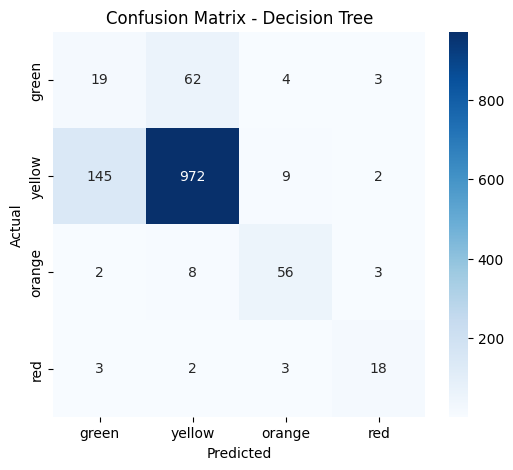

Classifier: Random Forest

              precision    recall  f1-score   support

       green       0.17      0.10      0.13        88
      yellow       0.93      0.95      0.94      1128
      orange       0.85      0.88      0.87        69
         red       0.69      0.92      0.79        26

    accuracy                           0.89      1311
   macro avg       0.66      0.72      0.68      1311
weighted avg       0.87      0.89      0.88      1311



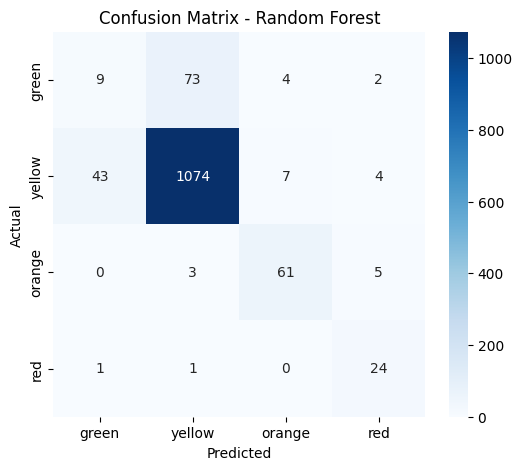

Classifier: Support Vector Machine

              precision    recall  f1-score   support

       green       0.08      0.56      0.13        88
      yellow       0.94      0.35      0.51      1128
      orange       0.39      0.81      0.52        69
         red       0.25      0.88      0.39        26

    accuracy                           0.40      1311
   macro avg       0.41      0.65      0.39      1311
weighted avg       0.84      0.40      0.49      1311



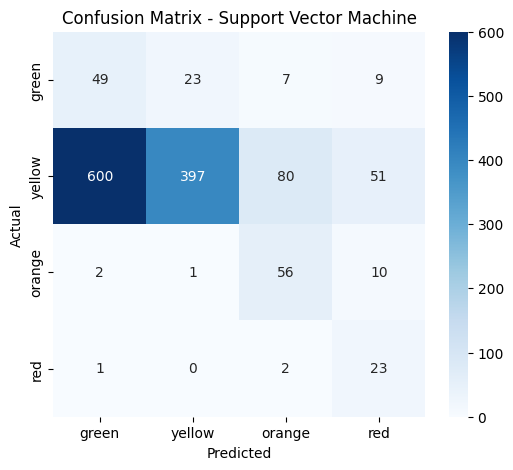

In [54]:
results = {}

for name, clf in classifiers.items():
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['green', 'yellow', 'orange', 'red'])
    results[name] = {'model': clf, 'report': report, 'conf_matrix': confusion_matrix(y_test, y_pred)}

# Display classification reports
for name, result in results.items():
    print(f"Classifier: {name}\n")
    print(result['report'])

    # Visualize confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=['green', 'yellow', 'orange', 'red'],
                yticklabels=['green', 'yellow', 'orange', 'red'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


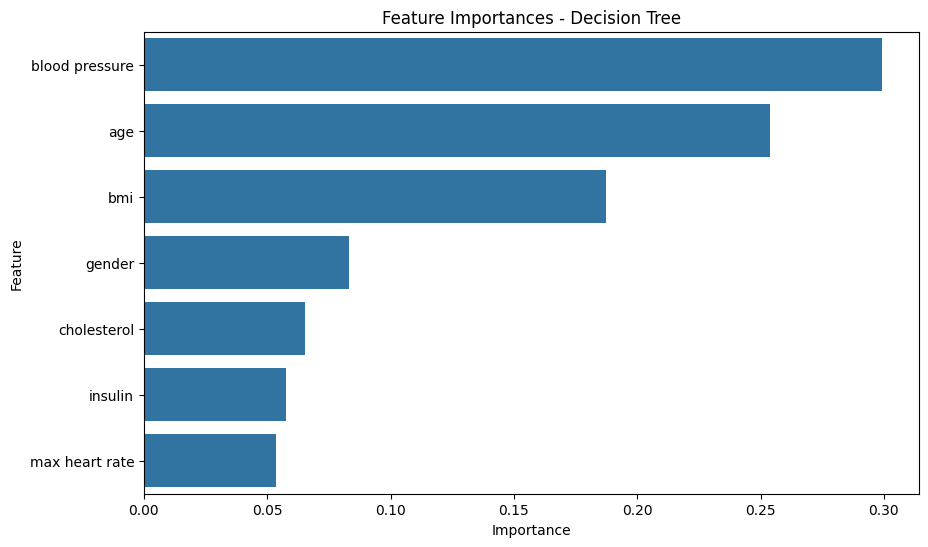

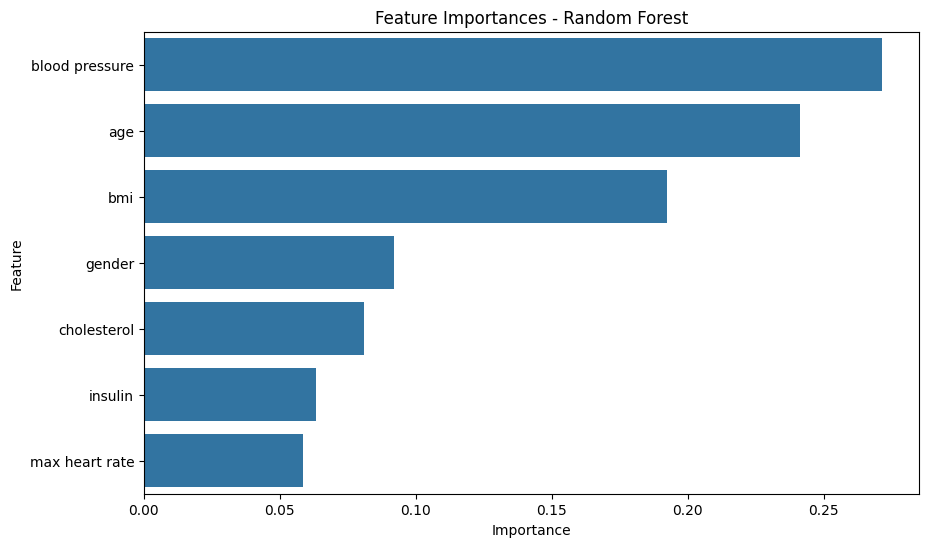

In [55]:

# Feature importance for Decision Tree and Random Forest
for name in ['Decision Tree', 'Random Forest']:
    model = results[name]['model']
    if hasattr(model, 'feature_importances_'):
        feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importances)
        plt.title(f'Feature Importances - {name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

Save the Random forest model

In [56]:
# Save the Random Forest model
import joblib

joblib.dump(results['Random Forest']['model'], 'random_forest_model.pkl')

print("Random Forest model has been saved as 'random_forest_model.pkl'")


Random Forest model has been saved as 'random_forest_model.pkl'
